# Hands-on Exercise — Neural Network Classification with LSS Power Spectra P(k)

In this exercise you will train a neural network to classify two cosmological models
based on **simulated matter power spectra** \(P(k)\).

We will simulate two classes:

- **Class 0**: baseline ΛCDM-like \(P(k)\)
- **Class 1**: modified \(P(k)\) with a feature/suppression/oscillation

Your tasks:

✅ Generate the dataset  
✅ Normalize inputs  
✅ Train a neural network classifier  
✅ Evaluate with learning curves + confusion matrix  
✅ Improve accuracy by changing one element (architecture)

This notebook is designed for a live session: it should run fast on CPU.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

rng = np.random.default_rng(0)
tf.random.set_seed(0)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True


## 1. Background (physics)

In large-scale structure, the **matter power spectrum** \(P(k)\) encodes how matter is distributed across scales.

- Large \(k\) = small scales
- Small \(k\) = large scales

Different cosmologies can change the *shape* of \(P(k)\), for example:
- changes in tilt,
- small-scale suppression,
- oscillatory features,
- baryon acoustic oscillation patterns (BAO).

Here we build a toy version of this idea:

We generate vectors \(P(k)\) sampled on a grid of \(k\) values,
then train a neural network to classify the model.


In [3]:
# k grid (log-spaced)
k = np.logspace(-3, 0, 200)  # from 1e-3 to 1

def pk_baseline(k, A=1.0, ns=0.96, k_damp=0.4):
    """
    Toy ΛCDM-like matter power spectrum:
    - power-law tilt with ns
    - exponential small-scale damping
    """
    pk = A * (k ** ns) * np.exp(-(k / k_damp)**2)
    return pk

def pk_feature_model(k, A=1.0, ns=0.96, k_damp=0.4,
                     amp=0.2, k0=0.1, width=0.05, freq=70):
    """
    Toy "feature model": baseline P(k) times a localized oscillatory feature.
    """
    pk0 = pk_baseline(k, A=A, ns=ns, k_damp=k_damp)
    bump = np.exp(-0.5*((k - k0)/width)**2) * np.sin(freq*(k-k0))
    return pk0 * (1.0 + amp*bump)


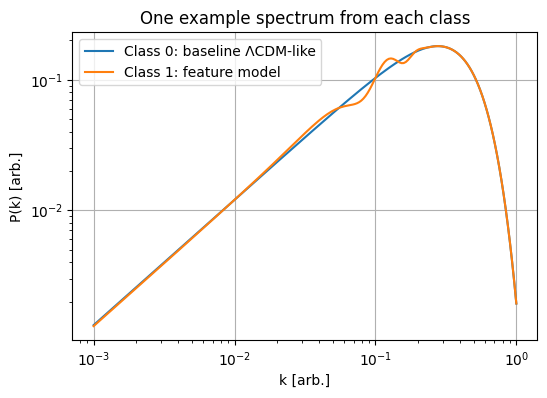

In [4]:
pk0 = pk_baseline(k)
pk1 = pk_feature_model(k)

plt.plot(k, pk0, label="Class 0: baseline ΛCDM-like")
plt.plot(k, pk1, label="Class 1: feature model")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("k [arb.]")
plt.ylabel("P(k) [arb.]")
plt.title("One example spectrum from each class")
plt.legend()
plt.show()


In [5]:
def generate_dataset(N=3000, noise_frac=0.05):
    X, y = [], []

    for i in range(N):
        # small baseline parameter variations
        A = rng.uniform(0.9, 1.1)
        ns = rng.uniform(0.92, 1.0)
        k_damp = rng.uniform(0.3, 0.6)

        if rng.random() < 0.5:
            pk = pk_baseline(k, A=A, ns=ns, k_damp=k_damp)
            label = 0
        else:
            amp = rng.uniform(0.15, 0.3)
            k0 = rng.uniform(0.06, 0.18)
            width = rng.uniform(0.02, 0.06)
            freq = rng.uniform(40, 90)

            pk = pk_feature_model(k, A=A, ns=ns, k_damp=k_damp,
                                  amp=amp, k0=k0, width=width, freq=freq)
            label = 1

        # multiplicative noise
        pk_obs = pk * (1.0 + rng.normal(0.0, noise_frac, size=pk.size))

        # log transform to compress dynamic range
        X.append(np.log(pk_obs + 1e-12))
        y.append(label)

    return np.array(X), np.array(y)

X, y = generate_dataset(N=3000, noise_frac=0.05)
print("X shape:", X.shape)
print("Class counts:", np.unique(y, return_counts=True))

X shape: (3000, 200)
Class counts: (array([0, 1]), array([1504, 1496]))


## 2. Exercise Tasks

### ✅ Task 1:
Split the dataset into train and validation sets.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

### ✅ Task 2:
Build and train a neural network classifier.


In [7]:
import tensorflow as tf
tf.keras.backend.clear_session()  #Clear previous models from memory

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

input_dim = X_train.shape[1]

def make_cmb_classifier():
    model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),
        Dense(1, activation="sigmoid")  #binary classification
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = make_cmb_classifier()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
epochs = 100
batch_size = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("Final training accuracy:", history.history["accuracy"][-1])
print("Final validation accuracy:", history.history["val_accuracy"][-1])

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4829 - loss: 0.8191 - val_accuracy: 0.4989 - val_loss: 0.7248
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5034 - loss: 0.7025 - val_accuracy: 0.4900 - val_loss: 0.6920
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5041 - loss: 0.7056 - val_accuracy: 0.5056 - val_loss: 0.6902
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4981 - loss: 0.7082 - val_accuracy: 0.5033 - val_loss: 0.6892
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5044 - loss: 0.7074 - val_accuracy: 0.5111 - val_loss: 0.6881
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5064 - loss: 0.7056 - val_accuracy: 0.5233 - val_loss: 0.6871
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5088 - loss: 0.7034 - val_accuracy: 0.5333 - val_loss: 0.6861
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5134 - loss: 0.7013 - val_accuracy: 0.5244 - v

### ✅ Task 3:
Evaluate the learning curves, plot ROC, AUC and the confusion matrix.

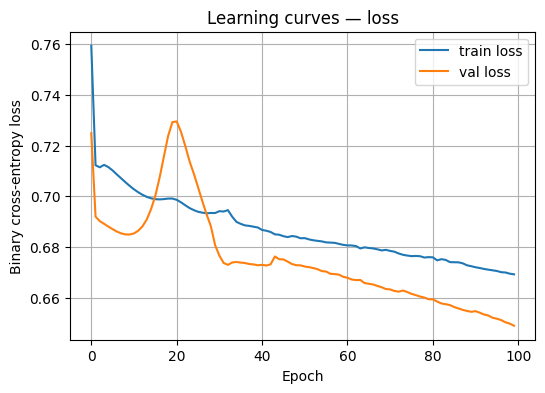

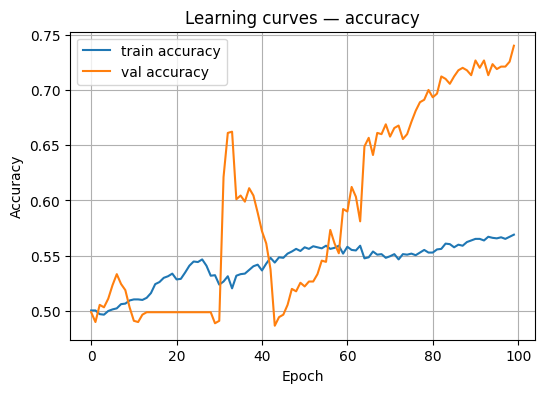

Validation accuracy: 0.740


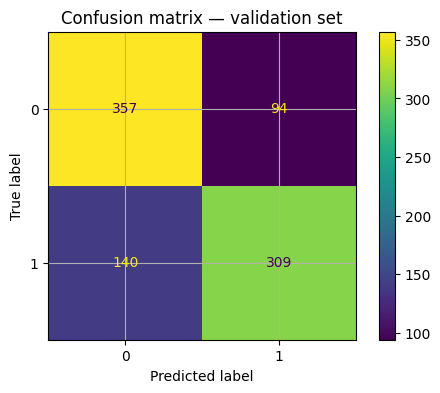

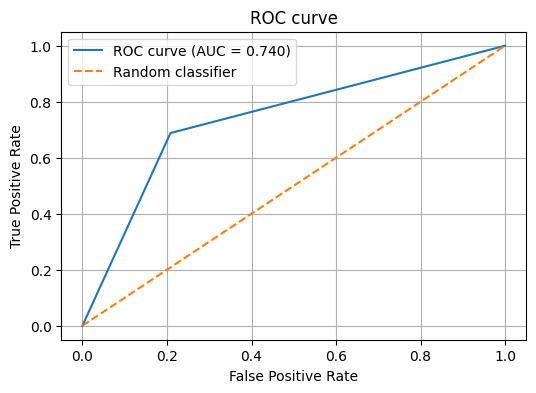

AUC: 0.7398851352352357


In [13]:
#Loss curves
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy loss")
plt.title("Learning curves — loss")
plt.legend()
plt.show()

#Accuracy curves
plt.figure()
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning curves — accuracy")
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def predict_labels(model, X):
    proba = model.predict(X, verbose=0)
    return (proba > 0.5).astype(int).ravel()

y_val_pred = predict_labels(model, X_val)

acc_val = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {acc_val:.3f}")

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion matrix — validation set")
plt.show()

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)

fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_pred)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

print("AUC:", auc)


### ✅ Task 4:
What happens if you change the batch size?

In [16]:
epochs = 100
batch_size = 20

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("Final training accuracy:", history.history["accuracy"][-1])
print("Final validation accuracy:", history.history["val_accuracy"][-1])

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7338 - loss: 0.5537 - val_accuracy: 0.7967 - val_loss: 0.5213
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7535 - loss: 0.5292 - val_accuracy: 0.7767 - val_loss: 0.5225
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7554 - loss: 0.5297 - val_accuracy: 0.7544 - val_loss: 0.5266
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7596 - loss: 0.5306 - val_accuracy: 0.7278 - val_loss: 0.5338
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7620 - loss: 0.5314 - val_accuracy: 0.6833 - val_loss: 0.5435
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7515 - loss: 0.5322 - val_accuracy: 0.6567 - val_loss: 0.5547
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7462 - loss: 0.5330 - val_accuracy: 0.6356 - val_loss: 0.5663
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7436 - loss: 0.5336 - val

### ✅ Task 5 (important):
Normalize the inputs using `StandardScaler` and retrain the model, what happens?

In [21]:
scaler = StandardScaler()
scaler.fit(X,y)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)
epochs = 100
batch_size = 64

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("Final training accuracy:", history.history["accuracy"][-1])
print("Final validation accuracy:", history.history["val_accuracy"][-1])

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7874 - loss: 0.4694 - val_accuracy: 0.8211 - val_loss: 0.4520
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8230 - loss: 0.4501 - val_accuracy: 0.8267 - val_loss: 0.4495
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8274 - loss: 0.4479 - val_accuracy: 0.8278 - val_loss: 0.4494
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8263 - loss: 0.4477 - val_accuracy: 0.8267 - val_loss: 0.4491
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8245 - loss: 0.4476 - val_accuracy: 0.8256 - val_loss: 0.4488
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8254 - loss: 0.4474 - val_accuracy: 0.8256 - val_loss: 0.4485
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8255 - loss: 0.4474 - val_accuracy: 0.8289 - val_loss: 0.4483
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8262 - loss: 0.4473 - val_accuracy: 0.8289

### ✅ Task 6:
Use Early stopping for getting to know how many training epochs are enough. Add: `callbacks=[early_stop]` to your `model.fit()` and change the patience. How many epochs are enough? Early stopping can be imported as:

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

print("Final training accuracy:", history.history["accuracy"][-1])
print("Final validation accuracy:", history.history["val_accuracy"][-1])


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8133 - loss: 0.4555 - val_accuracy: 0.8144 - val_loss: 0.4614
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8133 - loss: 0.4554 - val_accuracy: 0.8144 - val_loss: 0.4614
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8133 - loss: 0.4554 - val_accuracy: 0.8144 - val_loss: 0.4614
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8133 - loss: 0.4554 - val_accuracy: 0.8144 - val_loss: 0.4614
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8133 - loss: 0.4553 - val_accuracy: 0.8144 - val_loss: 0.4613
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8133 - loss: 0.4553 - val_accuracy: 0.8144 - val_loss: 0.4613
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8133 - loss: 0.4553 - val_accuracy: 0.8144 - val_loss: 0.4613
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8133 - loss: 0.4552 - val_accuracy: 0.81

### ✅ Task 7:
Play with Optuna. After doing the normalization, run the cell below:
Change the patience, which is the best suggested architecture?

In [29]:
!pip install optunahub
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.1 MB/s eta 0:00:00


In [30]:
import optuna

scaler = StandardScaler()
scaler.fit(X,y)
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

def objective(trial):
    #Hyperparameters to tune
    n1 = trial.suggest_int("n1", 16, 128, step=16)
    n2 = trial.suggest_int("n2", 16, 128, step=16)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    model = Sequential([
        Dense(n1, activation="relu", input_shape=(X_train_s.shape[1],)),
        Dense(n2, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    #Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    history = model.fit(
        X_train_s, y_train,
        validation_data=(X_val_s, y_val),
        epochs=100,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    #Return best validation accuracy achieved during training
    return max(history.history["val_accuracy"])

In [31]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

print("Best trial:", study.best_trial.params)
print("Best val accuracy:", study.best_value)

[I 2026-01-15 17:49:07,662] A new study created in memory with name: no-name-482f56f4-b85b-408d-8098-bb36f61e715e
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2026-01-15 17:49:23,413] Trial 0 finished with value: 0.5755555629730225 and parameters: {'n1': 32, 'n2': 112, 'lr': 0.001139963711453823, 'batch_size': 128}. Best is trial 0 with value: 0.5755555629730225.
[I 2026-01-15 17:49:28,931] Trial 1 finished with value: 0.5288888812065125 and parameters: {'n1': 48, 'n2': 80, 'lr': 0.0002917005961718044, 'batch_size': 128}. Best is trial 0 with value: 0.5755555629730225.
[I 2026-01-15 17:49:34,214] Trial 2 finished with value: 0.49888888001441956 and parameters: {'n1': 96, 'n2': 128, 'lr': 0.001853337024

Best trial: {'n1': 48, 'n2': 96, 'lr': 0.0003083232187673732, 'batch_size': 128}
Best val accuracy: 0.6755555272102356
